In [2]:
# Train a deep MLP on the MNIST dataset
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [4]:
from tensorflow import keras
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
# Train a deep MLP on the MNIST dataset

11493376/11490434 [==============================] - 4s 0us/step


In [5]:
X_train_full.shape

(60000, 28, 28)

In [6]:
X_train_full.dtype

dtype('uint8')

In [7]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
# valid : first 5000
# train : after the first 5000
# divide by 255 to scale to 0-1
X_test = X_test / 255.

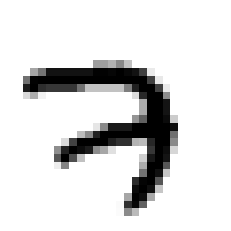

In [8]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [9]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

In [10]:
X_valid.shape

(5000, 28, 28)

In [12]:
X_train.shape

(55000, 28, 28)

In [13]:
X_test.shape

(10000, 28, 28)

In [14]:
# get over 98% precision
# searching for the optimal learning rate


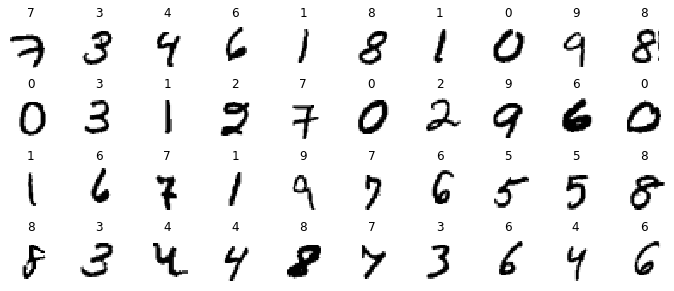

In [17]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest") # data
        plt.axis('off')
        plt.title(y_train[index], fontsize=12) # target
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [18]:
# searching for the optimal learning rate
# a callback to grow learning rate at each iteration
K = keras.backend


# define our callback
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = [] 
        # record the rates
        self.losses = []
        # record the losses
    def on_batch_end(self, batch, logs):
        # at the end of rach batch
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor) 
        # let the learning rate grow exponentially

In [19]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [20]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), # input shape
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax") # classify more than 3 and each is independent
])

In [21]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)
# grow 0.5% at each iteration

In [23]:
# train the model with one epoch at first
history = model.fit(X_train, y_train, epochs = 1,
                   validation_data=(X_valid, y_valid),
                   callbacks=[expon_lr])

1719/1719 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.5659 - val_loss: nan - val_accuracy: 0.0958


Text(0, 0.5, 'Loss')

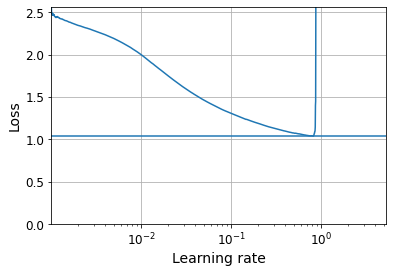

In [51]:
# plot the loss for learning rate
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log') # turn x axis into log
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates)) # (y, xmin, xmax)
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]]) # first 2 is x axis, the last 2 is y axis
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [42]:
# over 6e-1, The loss starts shooting back up violently 
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [43]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [44]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=3e-1), # 0.3
              metrics=["accuracy"])

In [49]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'.\\my_mnist_logs\\run_001'

In [52]:
#　apply callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
   1/1719 [..............................] - ETA: 0s - loss: 2.5649 - accuracy: 0.0625WARNING:tensorflow:From C:\Users\haoyu\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2352 - accuracy: 0.9267 - val_loss: 0.1000 - val_accuracy: 0.9724
Epoch 2/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0947 - accuracy: 0.9706 - val_loss: 0.0882 - val_accuracy: 0.9744
Epoch 3/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0666 - accuracy: 0.9790 - val_loss: 0.0801 - val_accuracy: 0.9752
Epoch 4/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0465 - accuracy: 0.9852 - val_loss: 0.0791 - val_accuracy: 0.9774
Epoch 5/100
1719/1719 [=============================

In [54]:
6e-1, 3e-1

(0.6, 0.3)

In [55]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0821 - accuracy: 0.0977


[0.0821206271648407, 0.09769999980926514]

In [57]:
%load_ext tensorboard
%tensorboard --logdir=./my_mnist_logs --port=6006
#open your web browser to localhost:6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 16140.